In [580]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm


from frt_distributions import GraphWalker, AnalyticalDistribution, DistributionDistance, calc_distance, generate_embedding, mean_variance_embedding, detect_communities
from visualisations import highlight_node_and_neighbors
from randomisations import randomise_graph, randomise2, compute_graph_similarity

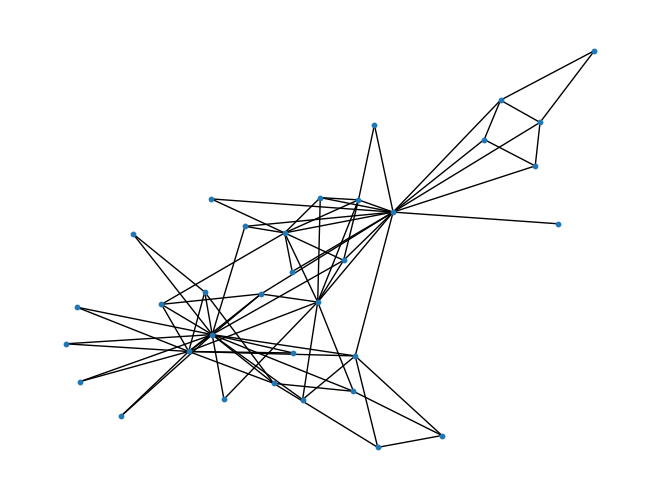

In [582]:
# Create a graph to randomise
G = nx.karate_club_graph()
for u, v in G.edges():
    G[u][v].clear()

k = 5
sizes = [5, 10, 5]
sizes = [100, 100]
p=0.9 ; q = 0.01
probs = [[p, q, q], [q, p, q], [q, q, p]]
probs = [[p, q], [q, p]]
#G = nx.stochastic_block_model(sizes, probs, seed=0)
#G = nx.read_gml('Little_rock_lake.gml', label='id').to_undirected()
#G.remove_edges_from(nx.selfloop_edges(G))
N = len(G.nodes)


nx.draw(G, node_size=10)


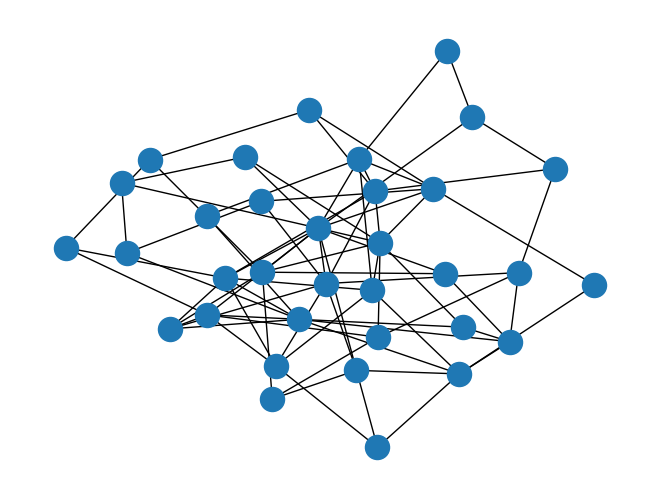

In [584]:
#Create a random graph
starting_graph = nx.gnm_random_graph(len(G.nodes), len(G.edges))
while not nx.is_connected(starting_graph):
    starting_graph = nx.gnm_random_graph(len(G.nodes), len(G.edges))
nx.draw(starting_graph)

In [586]:
nx.is_connected(starting_graph)

True

In [683]:
#Ensure choice of x leads to atleast 1 edge to change in proposals
N = len(G.nodes)
x = 1
    # Total possible pairs of nodes, excluding self-loops
total_pairs = N * (N - 1) // 2
    
    # Calculate number of pairs to randomize based on the percentage
int(total_pairs * x / 100)

5

In [931]:
randomised_graphs, diffs, full_diffs, betas = randomise_graph(original_graph=G,
                                                       n_chains = 1,
                                                       generate_embedding=generate_embedding,
                                                       starting_graph = starting_graph,
                                                       n_steps=30000,
                                                       burn_in=10000,
                                                       sample_interval=1,
                                                       beta =10000,
                                                       return_diff=True,
                                                       x=0.2,
                                                       M =20,
                                                       anneal=True,
                                                       adaptive=False,
                                                       ignore_burn_in = True,
                                                       beta_max = 40000, beta_min = 0,
                                                       epsilon=3e-5,
                                                       c=2000,
                                                       adaptation_rate =10000,
                                                       target_coeff=0.1,
                                                       linear=True, log=False)

Starting distance = 0.11098489575280493


100%|█████████████████████████████████████| 30000/30000 [08:11<00:00, 60.98it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '$d(G_0, G)$')

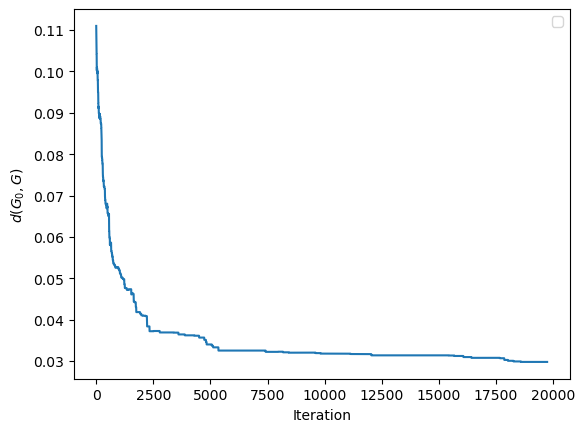

In [915]:
plt.plot(full_diffs)
#plt.vlines(50000, np.amin(full_diffs), np.amax(full_diffs), 'k', label='Start of observation')
plt.legend() ; plt.xlabel('Iteration') ; plt.ylabel(r'$d(G_0, G)$')

In [917]:
10000*(np.std(full_diffs[-100:])/np.mean(full_diffs[-100:]) - 0.05)

-499.99999999999767

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '$\\beta$')

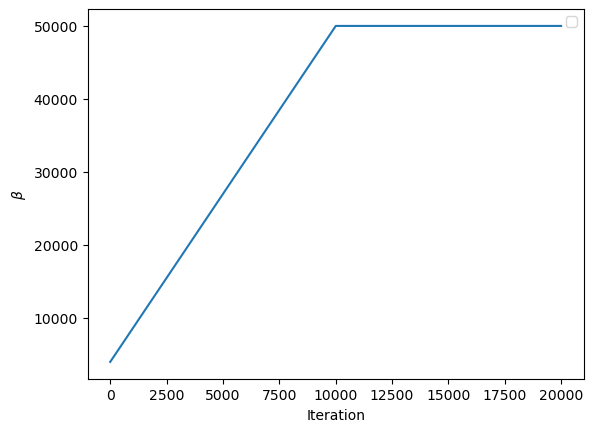

In [919]:
plt.plot(betas)
#plt.vlines(50000, np.amin(full_diffs), np.amax(full_diffs), 'k', label='Start of observation')
plt.legend() ; plt.xlabel('Iteration') ; plt.ylabel(r'$\beta$')

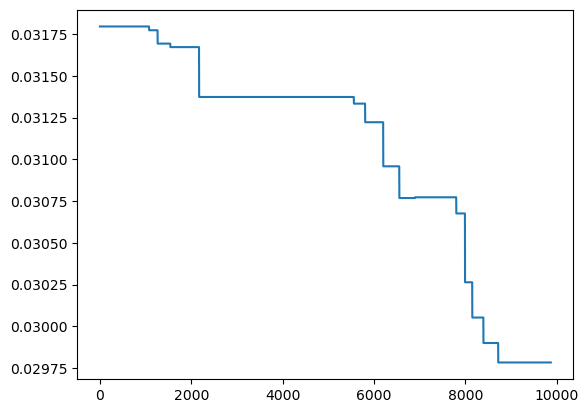

In [921]:
plt.plot(diffs)

(0.0, 0.03279499568312939)

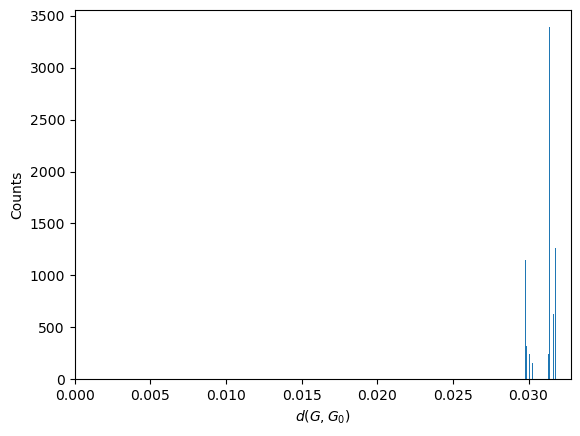

In [923]:
plt.hist(diffs, bins=50)
plt.xlabel(r'$d(G, G_0)$') ; plt.ylabel('Counts')
plt.xlim(0, max(diffs)+0.001)

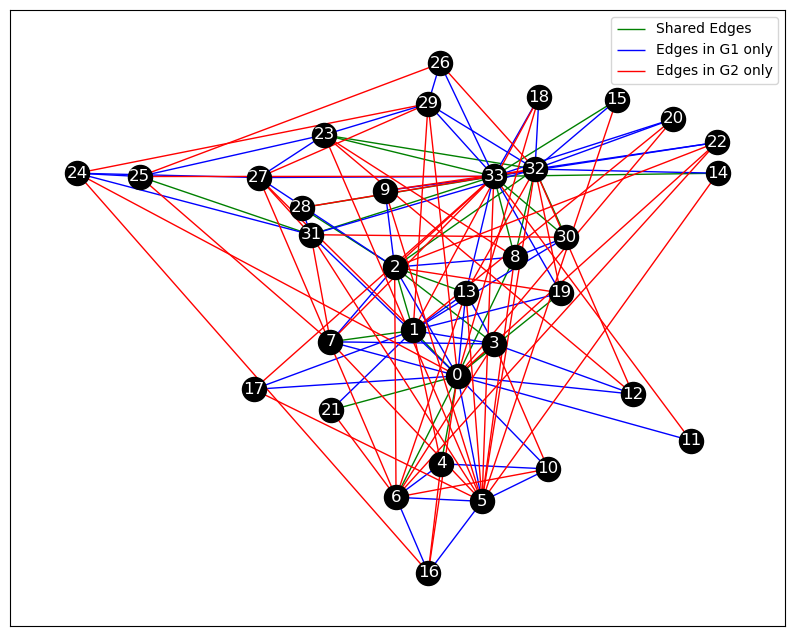

In [925]:
G1 = G ; G2 = randomised_graphs[-1]
pos = nx.spring_layout(G)
shared_edges = set(G1.edges()).intersection(set(G2.edges()))
G1_only_edges = set(G1.edges()) - shared_edges
G2_only_edges = set(G2.edges()) - shared_edges

# Draw the graphs

plt.figure(figsize=(10, 8))

# Draw shared edges
nx.draw_networkx_edges(G1, pos, edgelist=shared_edges, edge_color='green', width=1, label='Shared Edges')

# Draw edges only in G1
nx.draw_networkx_edges(G1, pos, edgelist=G1_only_edges, edge_color='blue', width=1, label='Edges in G1 only')

# Draw edges only in G2
nx.draw_networkx_edges(G2, pos, edgelist=G2_only_edges, edge_color='red', width=1, label='Edges in G2 only')

# Draw nodes
nx.draw_networkx_nodes(G1, pos, node_color='black', node_size=300)
nx.draw_networkx_labels(G1, pos, font_color='white')
plt.legend()

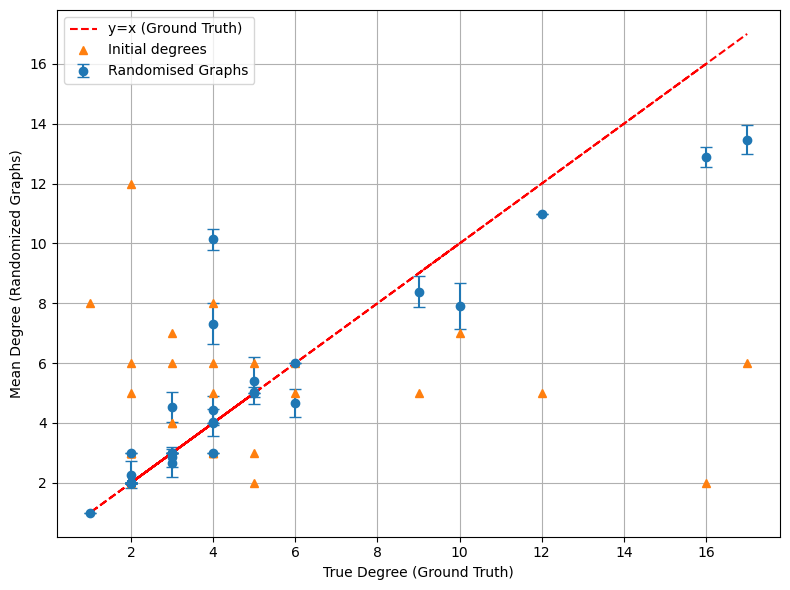

In [927]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Assume G is your ground truth graph
# Assume randomized_graphs is your list of NetworkX graphs

# Get the nodes in G (assumed to be the same for all randomized graphs)
nodes = list(G.nodes)

# Compute the true degrees for nodes in G
true_degrees = np.array([G.degree(node) for node in nodes])
initial_degrees = np.array([starting_graph.degree(node) for node in nodes])

# Compute the mean degree and standard deviation across randomized graphs
randomised_degrees = np.array([[graph.degree(node) for node in nodes] for graph in randomised_graphs])
mean_degrees = np.mean(randomised_degrees, axis=0)
std_degrees = np.std(randomised_degrees, axis=0)

# Plot the results
plt.figure(figsize=(8, 6))
plt.errorbar(true_degrees, mean_degrees, yerr=std_degrees, fmt='o', label="Randomised Graphs", capsize=4)
plt.plot(true_degrees, true_degrees, 'r--', label="y=x (Ground Truth)")
plt.plot(true_degrees, initial_degrees, '^', label="Initial degrees")
plt.xlabel("True Degree (Ground Truth)")
plt.ylabel("Mean Degree (Randomized Graphs)")
#plt.title("Mean Degree vs. True Degree with Error Bars")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


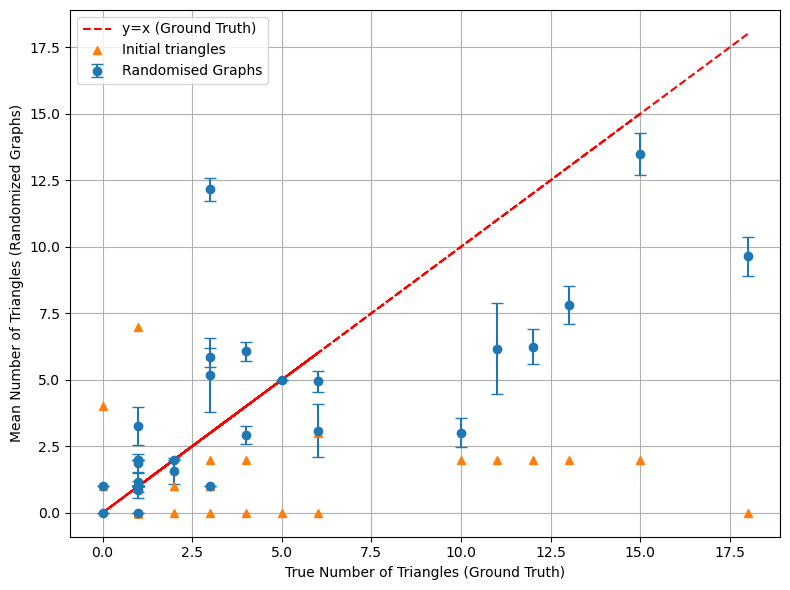

In [929]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Assume G is your ground truth graph
# Assume randomized_graphs is your list of NetworkX graphs

# Get the nodes in G (assumed to be the same for all randomized graphs)
nodes = list(G.nodes)

# Compute the true number of triangles for each node in G
true_triangles = np.array([nx.triangles(G, node) for node in nodes])

# Compute the number of triangles for each node across randomized graphs
randomised_triangles = np.array([[nx.triangles(graph, node) for node in nodes] for graph in randomised_graphs])
initial_triangles = np.array([nx.triangles(starting_graph, node) for node in nodes])

# Compute mean and standard deviation of triangles across randomized graphs
mean_triangles = np.mean(randomised_triangles, axis=0)
std_triangles = np.std(randomised_triangles, axis=0)

# Plot the results
plt.figure(figsize=(8, 6))
plt.errorbar(true_triangles, mean_triangles, yerr=std_triangles, fmt='o', label="Randomised Graphs", capsize=4)
plt.plot(true_triangles, true_triangles, 'r--', label="y=x (Ground Truth)")
plt.plot(true_triangles, initial_triangles, '^', label="Initial triangles")
plt.xlabel("True Number of Triangles (Ground Truth)")
plt.ylabel("Mean Number of Triangles (Randomized Graphs)")
#plt.title("Mean Number of Triangles vs. True Triangles with Error Bars")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Text(0, 0.5, 'Community label')

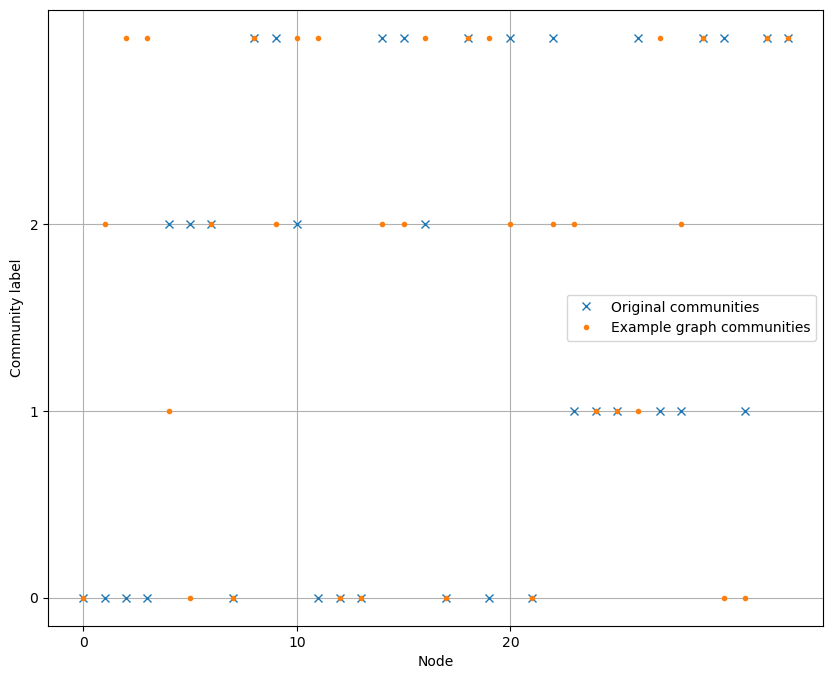

In [892]:
partition1 = detect_communities(G)
partition2 = detect_communities(randomised_graphs[-1])

fig = plt.figure(figsize=(10, 8))
plt.plot(partition1.keys(), partition1.values(), 'x', label='Original communities')
plt.plot(partition1.keys(), partition2.values(), '.', label='Example graph communities')
plt.xticks([0, 10, 20])
plt.yticks([0, 1, 2])
plt.grid()
plt.legend()
plt.xlabel('Node') ; plt.ylabel('Community label')